In [1]:
library(here)
library(tidyverse)
library(ggrepel)
library(bdkn)
library(data.table)
library(cowplot)

here() starts at /Users/martin_petr/projects/nea-over-time
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
#################################################################
##### load data
#################################################################

near_east <- c("BedouinB", "Yemenite_Jew", "Palestinian", "Iraqi_Jew", 
               "Jordanian","Druze", "Iranian", "Samaritan")

dt.asc <- readRDS('../data/rds/nea_ascertainment.rds')
dt.asc <- as.data.table(dt.asc)
dt.asc.samples <- dt.asc[sites == 'all' & snp_count > 200000 & !X %in% near_east & pop %in% c('WestEurasia', 'EMH'), unique(X)]

dt.asc.subset <- dt.asc[X %in% dt.asc.samples]
dt.asc.subset.ne <- dt.asc[X %in% dt.asc.samples | X %in% near_east]


basedir2 <- "../data/rds/"
dt.nea_est <- data.table(readRDS(sprintf("%s/%s", basedir2, "nea_estimates.rds")))

dt.nea_est <- 
  dt.nea_est %>%
  filter(!X %in% near_east,
         snp_count > 200000,
         stat == "admixture_prop" | 
           C == "Dinka" & stat == "indirect_f4" |
           C == "Dinka" & stat == "direct_f4" |
           stat == 'qpAdm',
         pop %in% c("EMH", "WestEurasia")) %>% as.data.table

In [3]:
#################################
#### functions
################################

## a function to get the "real" CI by sampling from the standard error for each point
compute_se_ci <- function(dt, my_n = 100, timespan = 45000, just_stats = F, null.m = 0) {
  dt.both_f4.reps = dt[, list(f4 = rnorm(my_n, alpha, stderr), rep = 1:my_n), by=list(X, age)]
  a = dt.both_f4.reps[, list(intercept=lm(f4~age)$coefficients[1],
                             slope=lm(f4~age)$coefficients[2]), by=rep]
  sq <- quantile(a$slope, c(.025,.5,.975))
  # print(sq)
  cat(sprintf('CI of N change over %g years\n', timespan))
  print(-sq*timespan)
  cat(sprintf('CI of slope (f4~age)\n', timespan))
  print(-sq)
  cat(sprintf('P(slope=%f) = %f\n', null.m, (1+sum(a$slope <= null.m)) / a[, .N+1]))
  
  if (just_stats) return(data.table(q025 = -sq[1]*timespan,
                                    q500 = -sq[2]*timespan,
                                    q975 = -sq[3]*timespan,
                                    p_gt0 = (1+sum(a$slope <= null.m)) / a[, .N+1]))
  
  a.ci_full <- a[, list(age = seq(0,50000,10),
                        intercept, slope), rep]
  a.ci_full[, f4 := intercept + slope * age]
  a.ci <- a.ci_full[, list(q_025 = quantile(f4, .025),
                           q_975 = quantile(f4, .975)), age]
}
dt.both_f4.ci <- compute_se_ci(dt.asc.subset[sites == 'all' & stat == 'direct_f4'])



plot_fig1 <- function(dt.nea_f4, my_n = 10000) {
  dt.nea_f4 <- data.table(dt.nea_f4)
  print('Direct f4')
  dt.nea_f4.ci.direct <- compute_se_ci(dt.nea_f4[stat == 'direct_f4'], my_n = my_n)
  print('Indirect f4')
  dt.nea_f4.ci.indirect <- compute_se_ci(dt.nea_f4[stat == 'indirect_f4'], my_n = my_n)
  dt.nea_f4[, f4 := alpha]
  ggplot(mapping=aes(x=age, y=f4)) + 
    scale_x_reverse(limits=c(46000,0)) +
    coord_cartesian(ylim=c(0,.045)) +
    
    geom_ribbon(data=dt.nea_f4.ci.indirect, aes(x=age, ymin=q_025, ymax=q_975, y=NULL, alpha='indirect_f4')) +
    geom_smooth(data=dt.nea_f4[stat=='indirect_f4'], aes(lty=stat), method='lm', se=F, color='black', size=.4) +
    
    geom_ribbon(data=dt.nea_f4.ci.direct, aes(x=age, ymin=q_025, ymax=q_975, y=NULL, alpha='direct_f4')) +
    geom_smooth(data=dt.nea_f4[stat=='direct_f4'], aes(lty=stat), method='lm', se=F, color='black') +
    
    geom_point(data=dt.nea_f4[stat=='indirect_f4'], aes(size=.5), alpha=.5, pch='x', show.legend = F) +
    geom_point(data=dt.nea_f4[stat=='direct_f4'], aes(size=snp_count/1e6), alpha=.5, stroke=0) +
    # geom_point(data=dt.nea_f4.ci, aes(x=age, y=q_025)) +
    geom_errorbar(data=dt.nea_f4[stat=='direct_f4'], aes(ymin=f4-stderr, ymax=f4+stderr), 
                  lty=1, color='black') +
    scale_size_area('SNP count\n(million)') +
    scale_linetype('statistic', 
                   labels = c('direct f4-ratio', 'indirect f4-ratio')) +
    scale_alpha_manual('statistic', values = c(.3,.1), 
                       labels = c('direct f4-ratio', 'indirect f4-ratio')) +
    theme_classic() +
    # theme(panel.grid.major = element_line(size=.1)) + #, color = rgb(1,1,1,1))) +
    # theme(legend.position = c(1,1), legend.justification = c(1.1,1.1)) +
    xlab('years before present') +
    ylab('Neandertal ancestry proportion') +
    NULL
}


CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0036829966 -0.0003284706 -0.0046330128 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 8.184437e-08 -7.299348e-09 -1.029558e-07 
P(slope=0.000000) = 0.455446


In [4]:
#################################################################
##### figure 01 now w/ indirect points
#################################################################

set_dim(5, 3, 300)

# p1 <- plot_fig1(dt.asc.subset[sites == 'all'], 10000)
p1 <- plot_fig1(dt.nea_est, 10000)
# p1

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0035387068 -0.0008749918 -0.0052495510 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 7.863793e-08 -1.944426e-08 -1.166567e-07 
P(slope=0.000000) = 0.343166
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02940064 -0.03456267 -0.03996448 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-6.533475e-07 -7.680593e-07 -8.880995e-07 
P(slope=0.000000) = 0.000100


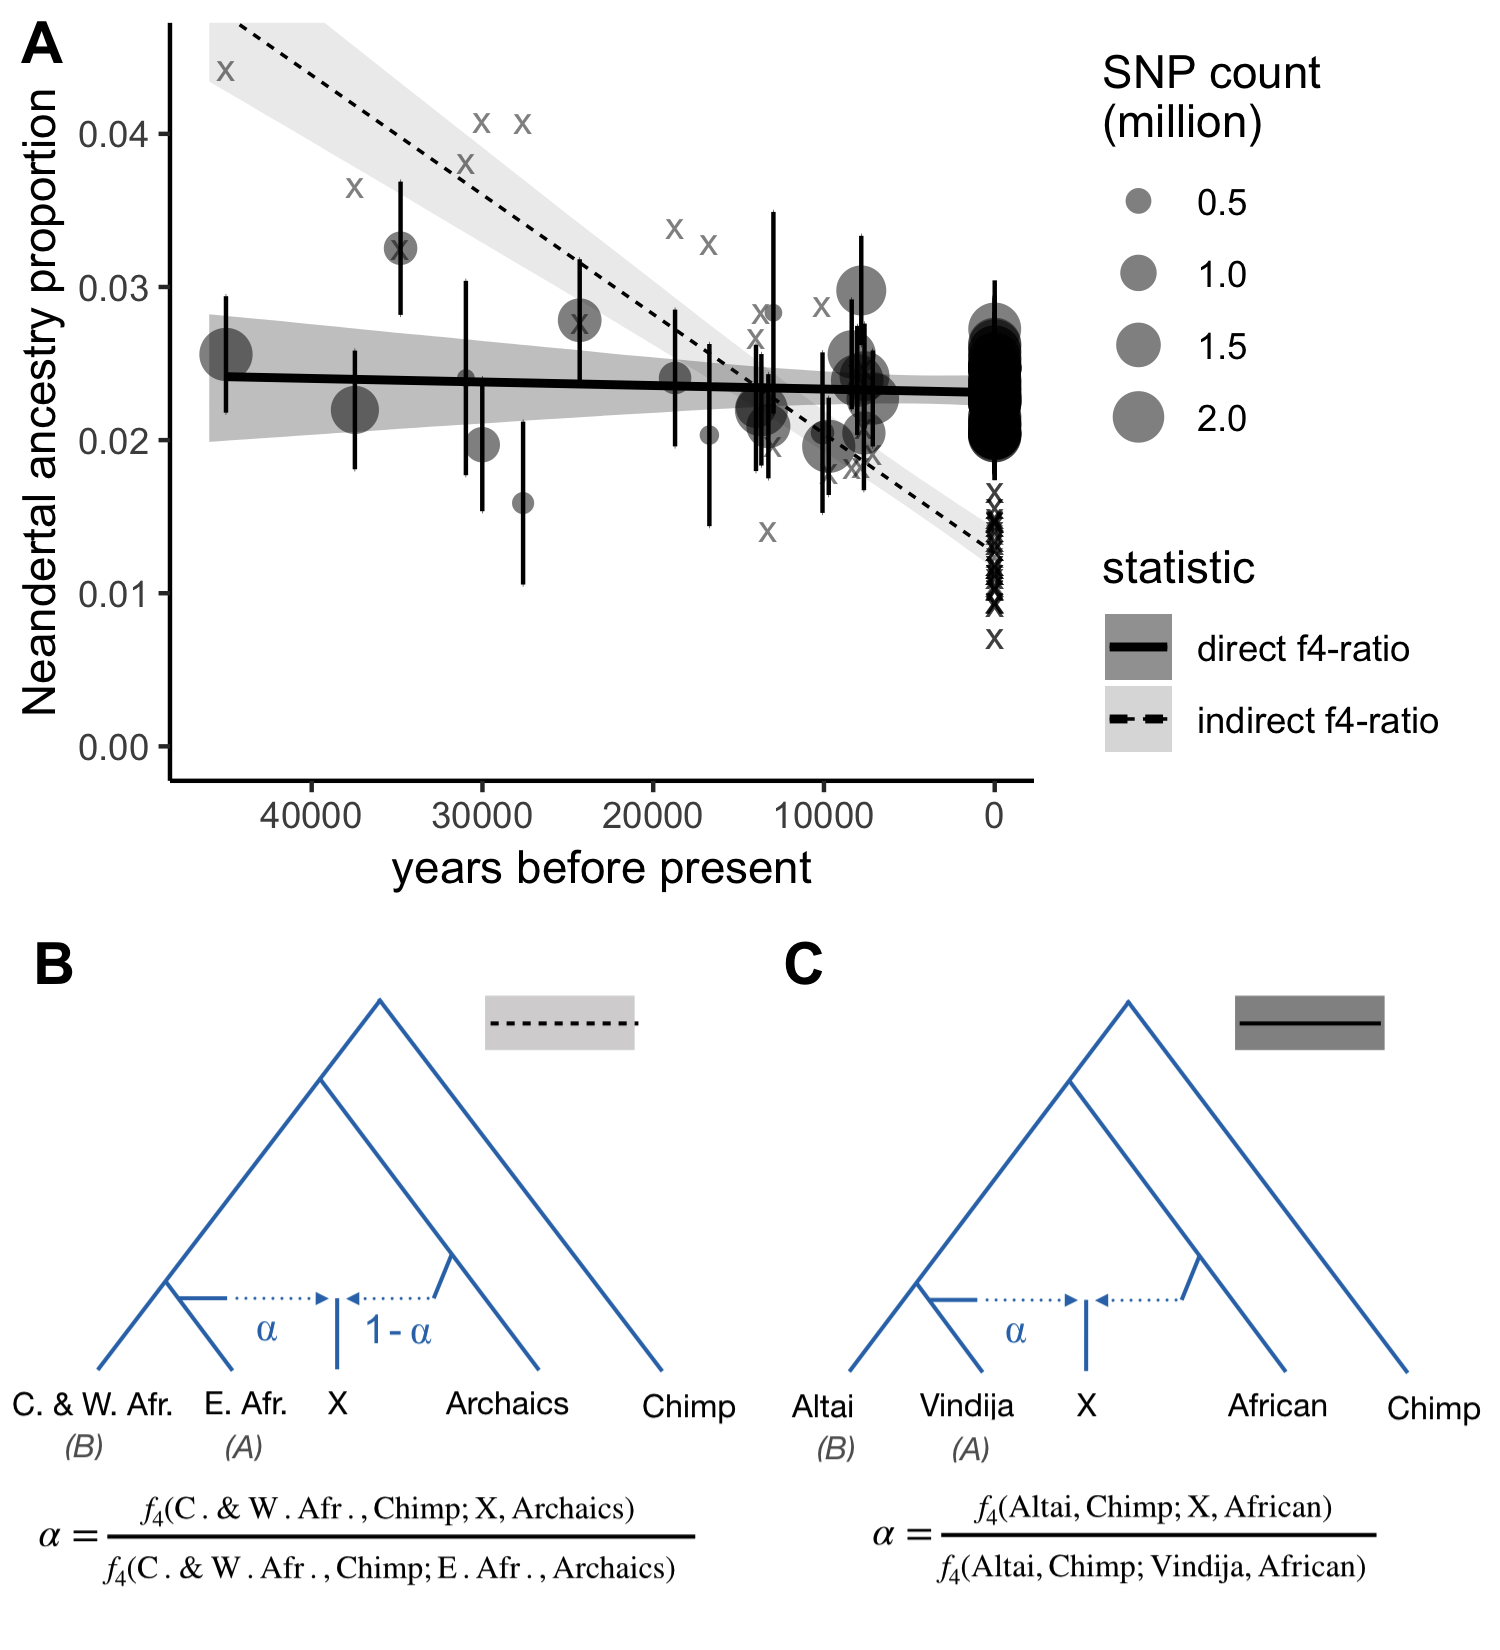

In [5]:
set_dim(5, 5.5, 300)

t1 <- ggdraw() + draw_image(here("figures/diagrams/trees_main.001.tiff"))
t2 <- ggdraw() + draw_image(here("figures/diagrams/trees_main.002.tiff"))

trees <- plot_grid(t1, t2, labels = c("B", "C"), vjust = 1.6, hjust = -0.8)

plot_grid(p1, trees, nrow = 2, labels = c("A", "", ""), rel_heights = c(1, 0.8))

ggsave(here("figures/1.pdf"), width = 5, height = 5.5, units = "in")

In [6]:
#################################################################
##### code to plot all the ascertainments - for a supplemental fig
#################################################################

ps1.all <- plot_fig1(dt.asc.subset[sites == 'all'], 1000) + 
  ggtitle(sprintf('All sites (%.1fk SNPs)', dt.asc.subset[sites == 'all', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0035764247 -0.0008501913 -0.0052167266 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 7.947610e-08 -1.889314e-08 -1.159273e-07 
P(slope=0.000000) = 0.344655
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02934547 -0.03441910 -0.03958474 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-6.521215e-07 -7.648689e-07 -8.796609e-07 
P(slope=0.000000) = 0.000999


In [7]:
ps1.ho_afr <- plot_fig1(dt.asc.subset[sites == 'ho_afr'], 1000) + 
  ggtitle(sprintf('HO Afr (%.1fk SNPs)', dt.asc.subset[sites == 'ho_afr', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.002664794 -0.004676360 -0.011932825 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 5.921765e-08 -1.039191e-07 -2.651739e-07 
P(slope=0.000000) = 0.112887
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02474589 -0.03000060 -0.03497566 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-5.499087e-07 -6.666801e-07 -7.772370e-07 
P(slope=0.000000) = 0.000999


In [8]:
ps1.ho_nonafr <- plot_fig1(dt.asc.subset[sites == 'ho_nonafr'], 1000) + 
  ggtitle(sprintf('HO nonAfr (%.1fk SNPs)', dt.asc.subset[sites == 'ho_nonafr', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
-0.0005150645 -0.0079457827 -0.0154439481 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-1.144588e-08 -1.765729e-07 -3.431988e-07 
P(slope=0.000000) = 0.019980
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.03322232 -0.04361367 -0.05417030 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-7.382738e-07 -9.691926e-07 -1.203784e-06 
P(slope=0.000000) = 0.000999


In [9]:
ps1.bigyri_YRI <- plot_fig1(dt.asc.subset[sites == 'bigyri_YRI'], 1000) + 
  ggtitle(sprintf('YRI hets (%.1fk SNPs)', dt.asc.subset[sites == 'bigyri_YRI', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.010591032  0.002069265 -0.006175217 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 2.353563e-07  4.598367e-08 -1.372270e-07 
P(slope=0.000000) = 0.676324
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.03140070 -0.04129858 -0.05222321 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-6.977933e-07 -9.177463e-07 -1.160516e-06 
P(slope=0.000000) = 0.000999


In [10]:
ps1.bigyri_Altai <- plot_fig1(dt.asc.subset[sites == 'bigyri_Altai'], 1000) + 
  ggtitle(sprintf('Altai hets (%.1fk SNPs)', dt.asc.subset[sites == 'bigyri_Altai', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.004409139 -0.013089997 -0.029053385 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 9.798088e-08 -2.908888e-07 -6.456308e-07 
P(slope=0.000000) = 0.067932
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02441710 -0.07458858 -0.12643404 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-5.426022e-07 -1.657524e-06 -2.809645e-06 
P(slope=0.000000) = 0.002997


In [11]:
ps1.afr_combined <- plot_fig1(dt.asc.subset[sites == 'afr_combined'], 1000) + 
  ggtitle(sprintf('HO Afr + YRI hets (%.1fk SNPs)', dt.asc.subset[sites == 'afr_combined', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.003654252 -0.002877234 -0.008842139 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 8.120559e-08 -6.393853e-08 -1.964920e-07 
P(slope=0.000000) = 0.179820
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02552635 -0.03086659 -0.03635352 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-5.672522e-07 -6.859241e-07 -8.078561e-07 
P(slope=0.000000) = 0.000999


In [12]:
ps1.remainder <- plot_fig1(dt.asc.subset[sites == 'remainder'], 1000) + 
  ggtitle(sprintf('Remainder (%.1fk SNPs)', dt.asc.subset[sites == 'remainder', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0107962408  0.0045391525 -0.0008725717 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 2.399165e-07  1.008701e-07 -1.939048e-08 
P(slope=0.000000) = 0.945055
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.03215284 -0.04020308 -0.04859916 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-7.145075e-07 -8.934017e-07 -1.079981e-06 
P(slope=0.000000) = 0.000999


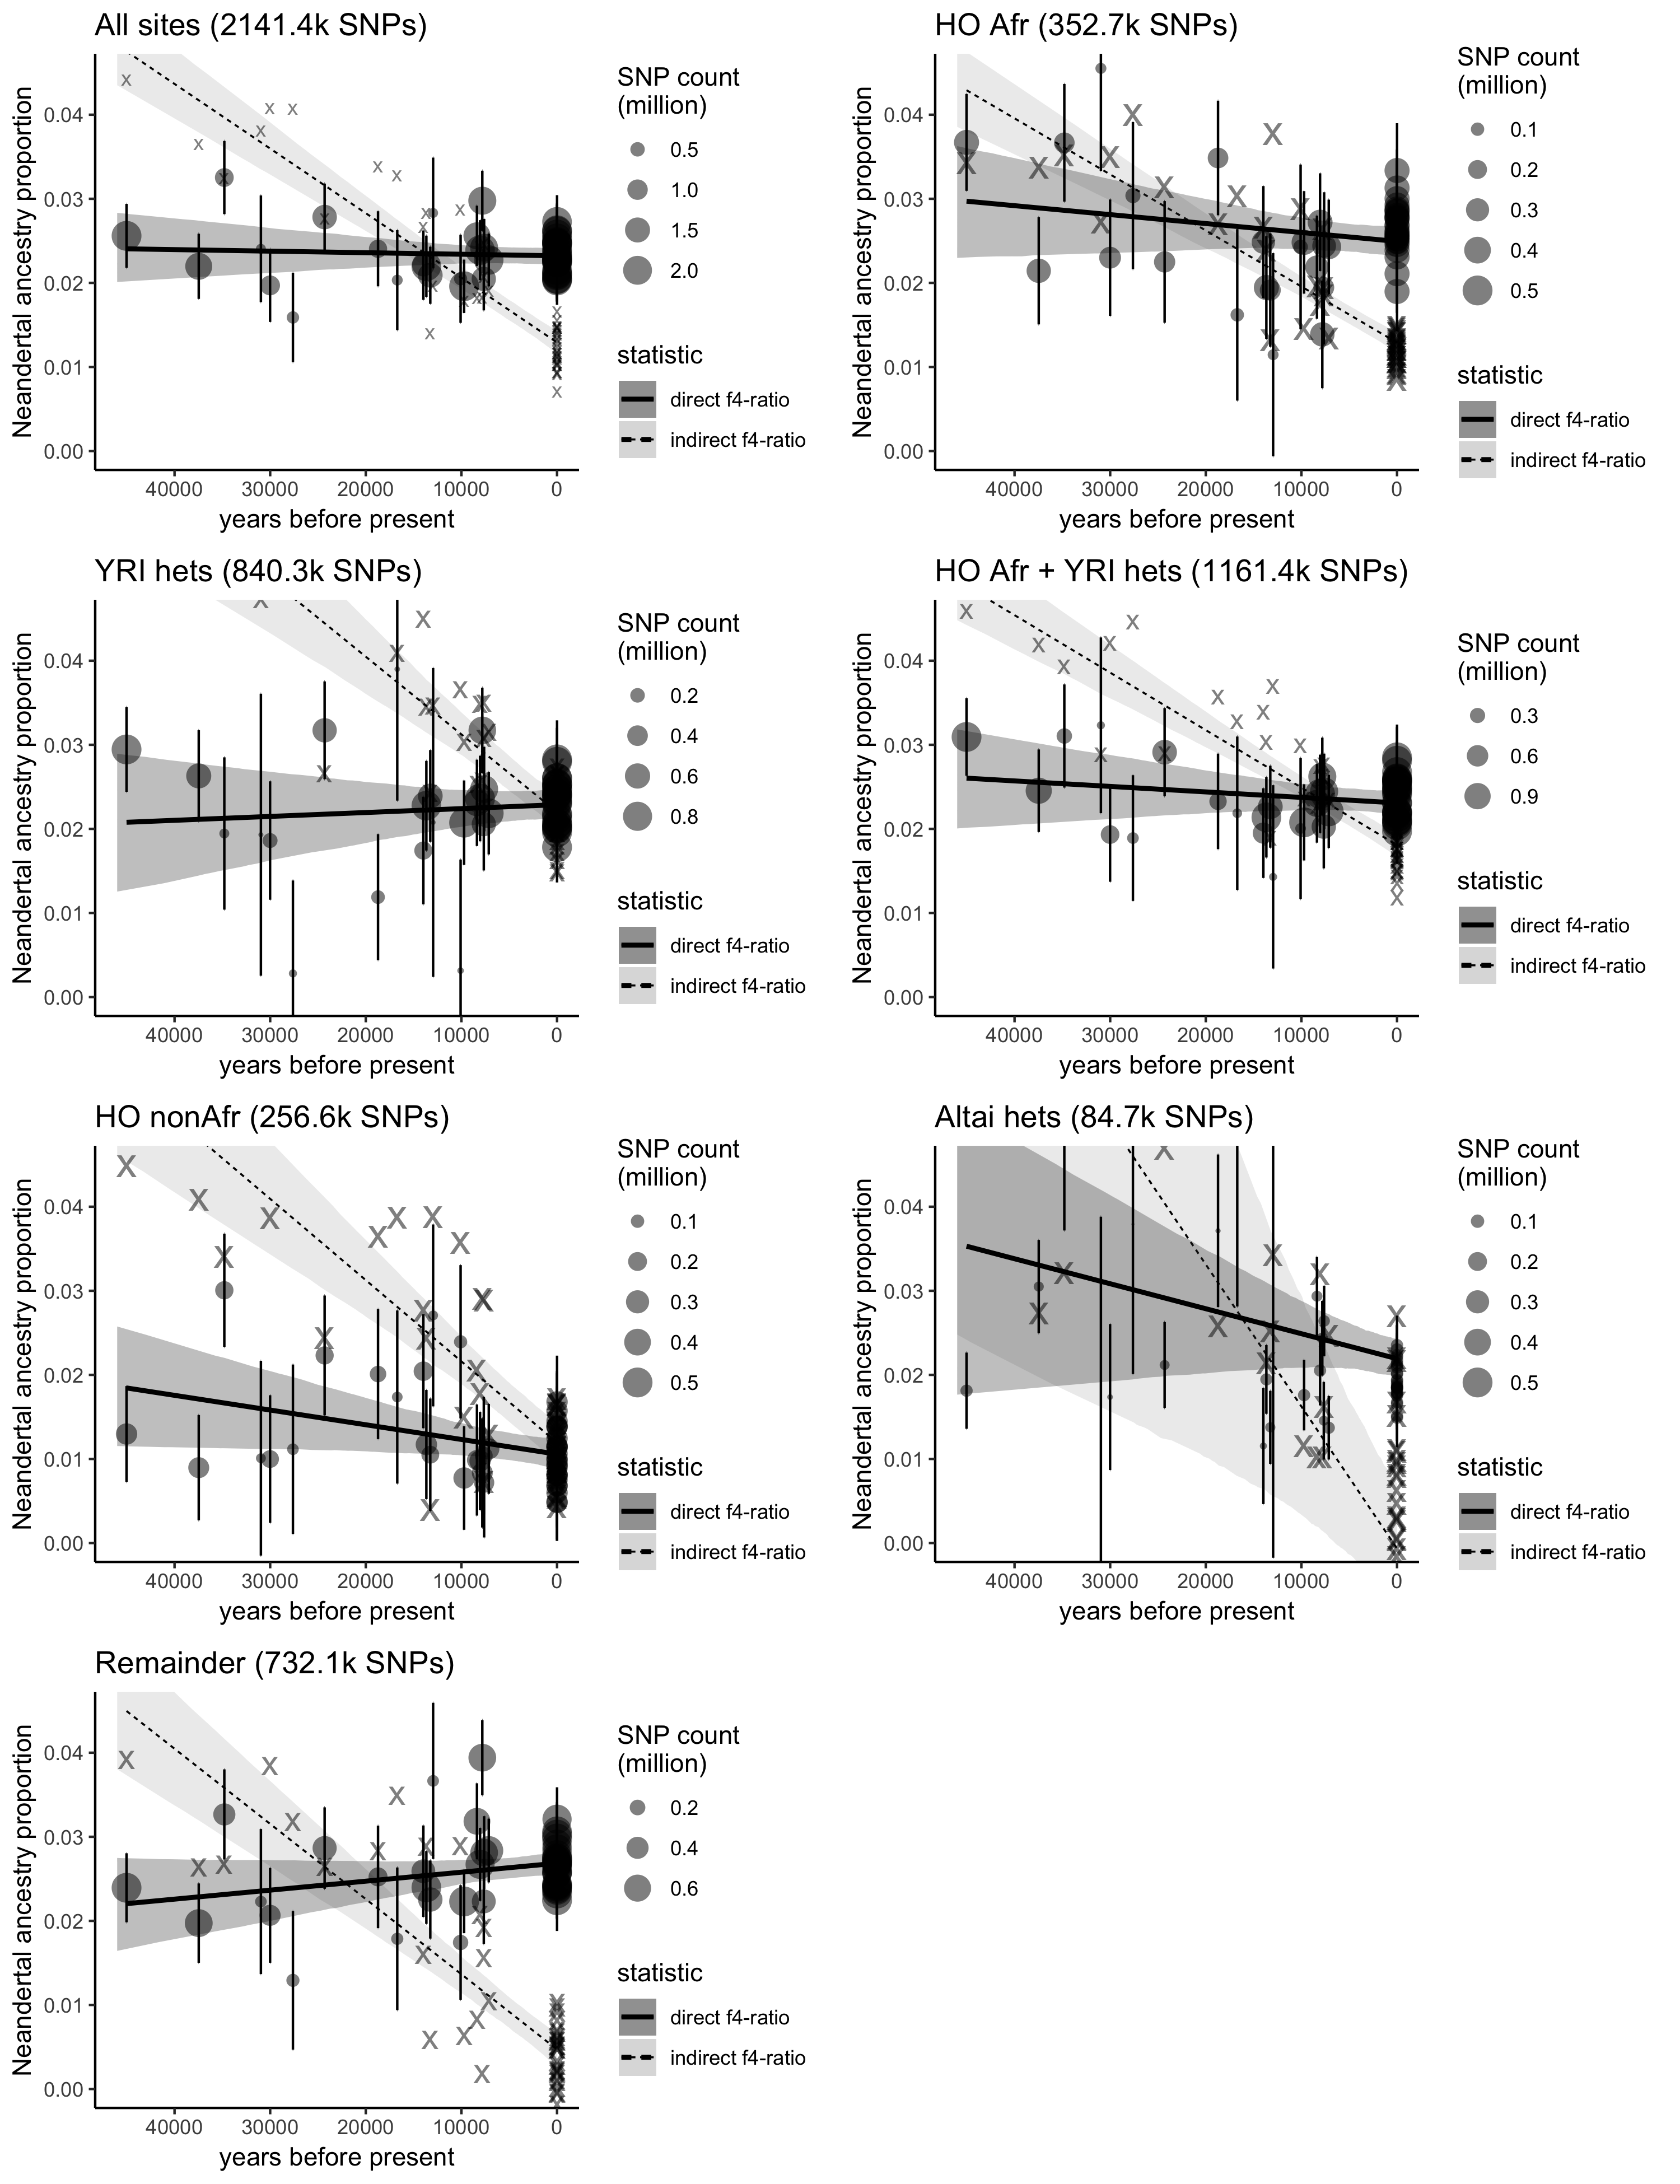

In [13]:
set_dim(10, 13, 300)

plot_grid(ps1.all, ps1.ho_afr, ps1.bigyri_YRI, ps1.afr_combined, 
          ps1.ho_nonafr, ps1.bigyri_Altai, ps1.remainder,
          ncol = 2)